In [1]:
# TODO
# Specify batch size
# Data augmentation e.g randomresizecrop, aug on gpu
# add callbacks
# try gradual unfreezing
# longer training

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *
from fastai2.vision.models.xresnet import xresnet50

import pandas as pd

In [4]:
images_path = '../data/resized_images'
labels_path = '../data/resized_labels.csv'
target_size = 320

In [5]:
y = pd.read_csv(labels_path, index_col='filename')

In [7]:
def get_y_func(x):
    filename = str(x).split('/')[-1]
    zipped = zip(list(y.loc[filename])[0::2], list(y.loc[filename])[1::2])
    return tensor(list(zipped))

pet_block = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y = lambda x: get_y_func(x),
    splitter=RandomSplitter()
)

In [12]:
tfms = aug_transforms(
    size=(320,320), 
    max_rotate=20, 
    max_zoom=1.5, 
    max_lighting=0.5, 
    max_warp=0.4, 
    p_affine=1., 
    p_lighting=1., 
)

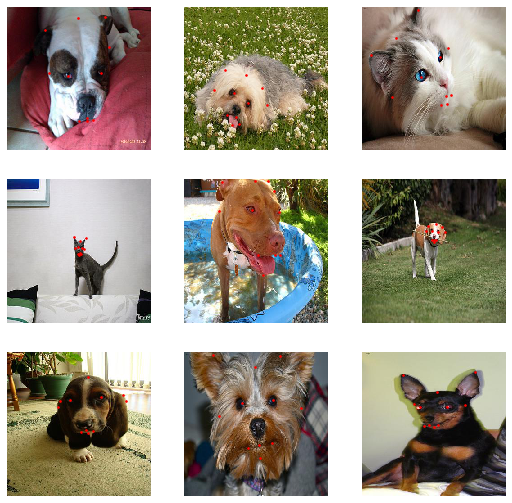

In [14]:
pet_dataloaders = pet_block.dataloaders(
    images_path,
    bs=32,
    batch_tfms=[
        *tfms, 
        Normalize.from_stats(*imagenet_stats),
        FlipItem(0.5),
    ]
)
pet_dataloaders.show_batch(max_n=9, vmin=1, vmax=30)

In [15]:
pet_dataloaders.c = pet_dataloaders.after_item.c
pet_dataloaders.train_ds.loss_func = MSELossFlat()

In [21]:
learn = cnn_learner(pet_dataloaders, xresnet50)

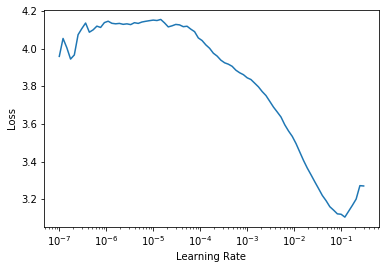

In [10]:
learn.lr_find()

In [22]:
learn.fit_one_cycle(5, slice(1e-2))

epoch,train_loss,valid_loss,time
0,0.453602,0.080904,03:11


In [24]:
learn.predict(pet_dataloaders.train_ds.items[0])

(TensorPoint([[115.1233, 104.6170],
         [112.0731,  81.0352],
         [147.7755,  54.2115],
         [211.3432,  75.6460],
         [201.9597, 101.0738],
         [142.1802, 179.1583],
         [111.9072, 108.1352],
         [194.1225, 128.8260],
         [149.5760, 170.6816],
         [159.5836, 156.6688],
         [142.6155, 181.5054]]),
 tensor([-0.2805, -0.3461, -0.2995, -0.4935, -0.0764, -0.6612,  0.3209, -0.5272,
          0.2622, -0.3683, -0.1114,  0.1197, -0.3006, -0.3242,  0.2133, -0.1948,
         -0.0652,  0.0668, -0.0026, -0.0208, -0.1087,  0.1344]),
 tensor([-0.2805, -0.3461, -0.2995, -0.4935, -0.0764, -0.6612,  0.3209, -0.5272,
          0.2622, -0.3683, -0.1114,  0.1197, -0.3006, -0.3242,  0.2133, -0.1948,
         -0.0652,  0.0668, -0.0026, -0.0208, -0.1087,  0.1344]))

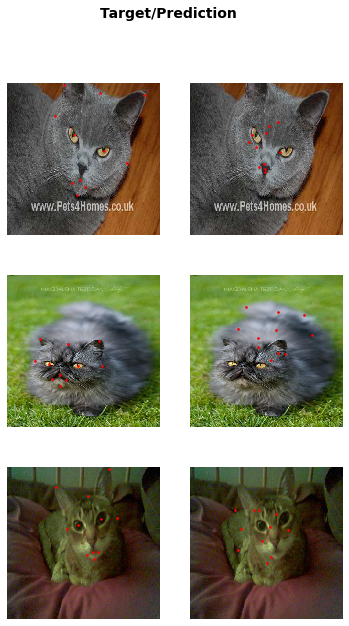

In [23]:
learn.show_results()

In [25]:
learn.summary()

Sequential (Input shape: ['32 x 3 x 320 x 320'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               32 x 32 x 160 x 160  864        False     
________________________________________________________________
BatchNorm2d          32 x 32 x 160 x 160  64         True      
________________________________________________________________
ReLU                 32 x 32 x 160 x 160  0          False     
________________________________________________________________
Conv2d               32 x 32 x 160 x 160  9,216      False     
________________________________________________________________
BatchNorm2d          32 x 32 x 160 x 160  64         True      
________________________________________________________________
ReLU                 32 x 32 x 160 x 160  0          False     
________________________________________________________________
Conv2d               32 x 64 x 160 x 160  18,432     False     
_________________________________________________